# Fantasy (first steps)
This shows how to use Pandas to manipulate roster data.

$\rightarrow$ Use `[Control] + [Enter]` to evaluate a cell. (Check the 'Help' menu above for more.)

In [1]:
##
# Setup -- import the modules we want and set up inline plotting
#
from __future__ import print_function
import datetime
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Bigger fonts and figures for the demo
matplotlib.rcParams.update({
        'font.size': 14,
        'figure.figsize':(10.0, 8.0),
        'axes.formatter.useoffset':False })

# Better data frame display for the demo
pd.set_option('expand_frame_repr', True)
pd.set_option('max_rows', 18)
pd.set_option('max_colwidth', 14)
pd.set_option('precision',2)

## First we need to load the data

It's the total 2014 stats for people who started in NFL games last year. Thanks to [TeamRankings.com][teamrankings]. We're missing the count of safeties but hopefully they're so infrequent they don't affect rankings.

[teamrankings]: https://www.teamrankings.com/

In [2]:
##
# Player data and the season schedule (for byes)
import os

player_stats_file = os.path.join('data', 'nfl_player_stats_season2014.csv')
season2015_file = os.path.join('data', 'nfl_season2015.csv')
prior_seasons_file = os.path.join('data', 'nfl_season2008to2014.csv')

stats = pd.read_csv(player_stats_file)
season2015 = pd.read_csv(season2015_file)
prior_seasons = pd.read_csv(prior_seasons_file)  # Don't delete this, we need it later

stats.columns

Index([u'Team', u'Player', u'pos', u'starts', u'fumblesLost', u'twoPt',
       u'passingATT', u'passingCOMP', u'passingINT', u'passingTD',
       u'passingYDS', u'receivingREC', u'receivingTD', u'receivingYDS',
       u'rushingATT', u'rushingTD', u'rushingYDS', u'kicking_extraPt',
       u'kicking_FGge50A', u'kicking_FGge50M', u'kicking_FGlt50A',
       u'kicking_FGlt50M', u'defenseF', u'defenseSCK', u'defenseTOT',
       u'defenseFumblesRecovered', u'fumblesRecoveredTD', u'pointreturnsFC',
       u'pointreturnsRETURNS', u'pointreturnsTD', u'interceptionsINT',
       u'interceptionsTD', u'interceptionsYDS', u'kickreturnsRETURNS',
       u'kickreturnsTD', u'kickreturnsYDS'],
      dtype='object')

### Column definitions

- `Team` - the full team name, exactly the same as in the other datasets
- `player` - the player name, plus team totals (`TOTAL`) and opponent totals (`OPPONENT TOTAL`)
- `pos` - abbreviation for positions, such as `QB`=quarterback, `K`=kicker
- `starts` - number of starts in the 2014 season
- `fumblesLost` - fumbles lost to the opposing team in 2014
- `fumblesRecoveredTD` - fumbles recovered for a touchdown in 2014
- `twoPt` - two point conversion
- **Passing**
    + `passingATT` - attempted passes in 2014
    + `passingCOMP` - completed passes in 2014
    + `passingINT` - intercepted passes in 2014
    + `passingTD` - passing touchdowns in 2014
    + `passingYDS` - passing yards in 2014
- **Receiving**
    + `receivingREC` - receptions in 2014
    + `receivingTD` - touchdowns made off of a reception in 2014
    + `receivingYDS` - receiving yards in 2014
- **Rushing**
    + `rushingATT` - rushing attempts in 2014
    + `rushingTD` - rushing touchdowns in 2014
    + `rushingYDS` - rushing yards in 2014
- **Kicking**
    + `kicking_extraPt` - extra points made in 2014
    + `kicking_FGge50A` - field golds $\ge$ 50 yards attempted
    + `kicking_FGge50M` - field golds $\ge$ 50 yards made
    + `kicking_FGlt50A` - field golds $\lt$ 50 yards attempted
    + `kicking_FGlt50M` - field golds $\lt$ yards made
- **Defense**
    + `defenseF` - fumbles forced in 2014
    + `defenseSCK` - sacks in 2014
    + `defenseTOTAL` - tackles in 2014
    + `defenseFumblesRecovered` - fumbles recovered in 2014
    + `pointreturnsFC` - fair catches on point returns in 2014
    + `pointreturnsRETURNS` - returns made on point returns in 2014
    + `pointreturnsTD` - point returns for a touchdown in 2014
    + `interceptionsINT` - interceptions in 2014
    + `interceptionsTD` - interceptions for a touchdown in 2014
    + `interceptionsYDS` - yards gained on interceptions in 2014
    + `kickreturnsRETURNS` - kick returns in 2014
    + `kickreturnsTD` - kick returns returned for a touchdown in 2014
    + `kickreturnsYDS` - yards gained during kick returns in 2014

### Aggregate the fumble recovery data for the defense

In Fantasy Football, you choose a defensive team, not individual players.

The dataset we have has rows in the column `player` as 'TOTAL' and 'OPPONENT TOTAL' for total defensive stats, except for safeties *(which I couldn't get easily - but which also are so rare that they shoudn't affect rankings too badly)* and fumbles recovered for a touchdown (`fumblesRecoveredTD`) which were from a separate dataset and not added in.

We need to aggregate `fumblesRecoveredTD` over the individual players to get a score for the defense.

In [3]:
byteam_fumbleRecoveries = stats.groupby('Team').fumblesRecoveredTD.agg({'totalFumblesRecoveredTD': 'sum'}).reset_index()
byteam_fumbleRecoveries.describe()

,totalFumblesRecoveredTD
count,21.0
mean,1.2
std,0.5
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,3.0


#### Add the fumble recoveries to the overall defensive team's stats
The overall stats are in rows for each team with the player name as `TOTAL`:

In [4]:
stats[stats.Player == 'TOTAL'][[
        'Player', 'Team',
        'interceptionsINT', 'interceptionsTD',
        'pointreturnsTD', 'kickreturnsTD', 'fumblesRecoveredTD',
        'defenseSCK', 'defenseF']]

,Player,Team,interceptionsINT,interceptionsTD,pointreturnsTD,kickreturnsTD,fumblesRecoveredTD,defenseSCK,defenseF
18,TOTAL,Houston Te...,3,1,0,0,NaN,9,1
78,TOTAL,Green Bay ...,18,3,2,0,NaN,41,12
127,TOTAL,Minnesota ...,13,2,0,0,NaN,41,9
184,TOTAL,Cleveland ...,21,2,0,0,NaN,31,15
234,TOTAL,Jacksonvil...,6,1,0,0,NaN,45,19
290,TOTAL,New York Jets,6,0,0,0,NaN,45,9
349,TOTAL,Arizona Ca...,18,3,1,0,NaN,35,9
433,TOTAL,New York G...,17,0,0,0,NaN,47,15
464,TOTAL,Baltimore ...,11,1,0,1,NaN,49,16
...,...,...,...,...,...,...,...,...,...


#### Merge the `byteam_fumbleRecoveries` stats back into the original stats frame
1. Add a false player name 'TOTAL' to the `byteam_fumbleRecoveries` data frame. We will merge on that name plus the team to select the correct row.
2. Merge `byteam_fumbleRecoveries` back into the `stats` data frame, matching on the same team name (and with `player` as the `TOTAL`).
3. Coalesce the aggregated column and the original column together
4. Delete the column `totalFumblesRecoveredTD` (which we made for the aggregation).

In [5]:
# 1. Add the 'player' column with value 'TOTAL'
byteam_fumbleRecoveries['Player'] = 'TOTAL'

# 2. Merge (left join) to add the 'fumblesRecoveredTD' values to the 'stats' data frame.
stats = stats.merge(byteam_fumbleRecoveries, on=['Team', 'Player'], how='left')

# 3. Coalesce the two columns together into the original column
#    (when I am assigning to a subset of rows I have to use the '.ix' accessor.
#     The other one -- just [] -- will return a copy of the column and so
#     the assignment will take place on the copy, not the original.)
stats.ix[stats.fumblesRecoveredTD.isnull(), 'fumblesRecoveredTD'] = stats[
    stats.fumblesRecoveredTD.isnull()].totalFumblesRecoveredTD

# 4. Delete the column totalFumblesRecoveredTD.
del stats['totalFumblesRecoveredTD']

# Show the result
stats[stats.Player=='TOTAL'][['Team'] + [c for c in stats.columns if c.endswith('TD')]]

,Team,passingTD,receivingTD,rushingTD,fumblesRecoveredTD,pointreturnsTD,interceptionsTD,kickreturnsTD
18,Houston Te...,NaN,NaN,NaN,1,0,1,0
78,Green Bay ...,NaN,NaN,NaN,1,2,3,0
127,Minnesota ...,NaN,NaN,NaN,1,0,2,0
184,Cleveland ...,NaN,NaN,NaN,1,0,2,0
234,Jacksonvil...,NaN,NaN,NaN,2,0,1,0
290,New York Jets,NaN,NaN,NaN,NaN,0,0,0
349,Arizona Ca...,NaN,NaN,NaN,1,1,3,0
433,New York G...,NaN,NaN,NaN,1,0,0,0
464,Baltimore ...,NaN,NaN,NaN,NaN,0,1,1
...,...,...,...,...,...,...,...,...


### Select only the players we want
For standard fantasy, you get 9 players on your starting roster and 6 players on the bench.
The defensive players are rolled into one (we just did that for the last relevant type of scoring play) and we don't care about the other positions.

The parenthesized abbreviations are the corresponding value in the `pos` column in this dataset:

- Quarterback (`QB`):1
- Running Back (`RB`):2
- Wide Receiver (`WR`):2
- Tight End (`TE`):1
- Wide Receiver / Running Back:1
- Kicker (`K`):1
- Defensive Team:1
- Bench:6

First, let's add a value `'DEFENSE'` as the position when the player is named `'TOTAL'`. Then we'll delete all of the players who aren't the kinds we can use.

In [6]:
# These are the positions
stats.pos.unique()

array([nan, 'CB', 'K', 'RB', 'LB', 'DT', 'C', 'WR', 'DE', 'T', 'QB', 'TE',
       'S', 'PK', 'FB', 'DB', 'P', 'G', 'NT'], dtype=object)

In [7]:
# 1. Add a value 'DEFENSE' as the position when the player is named 'TOTAL'
stats.ix[stats.Player == 'TOTAL', 'pos'] = 'DEFENSE'

# 2. Delete players that aren't the types used in Fantasy
stats = stats[stats.pos.isin(('QB', 'RB', 'WR', 'TE', 'K', 'DEFENSE'))]

print(stats.shape)

stats.head(6)

(194, 36)


,Team,Player,pos,starts,fumblesLost,twoPt,passingATT,passingCOMP,passingINT,passingTD,...,fumblesRecoveredTD,pointreturnsFC,pointreturnsRETURNS,pointreturnsTD,interceptionsINT,interceptionsTD,interceptionsYDS,kickreturnsRETURNS,kickreturnsTD,kickreturnsYDS
18,Houston Te...,TOTAL,DEFENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,5,13,0,3,1,69,6,0,116
31,Houston Te...,Randy Bullock,K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,Green Bay ...,Eddie Lacy,RB,18,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,Green Bay ...,TOTAL,DEFENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,12,29,2,18,3,396,29,0,555
89,Green Bay ...,Randall Cobb,WR,18,2,1,NaN,NaN,NaN,NaN,...,NaN,9,14,0,NaN,NaN,NaN,1,0,0
95,Green Bay ...,Mason Crosby,K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Ranking the players
...finally!


### Fantasy scoring

The scoring shown in the table below uses the [NFL fantasy standard rules][nfl_standard]. The `fixed width` denotes the corresponding column name in the dataset.


<table style="font-size:70%;">
<tr><th>Offense</th><th>Kicking</th><th>Defense</th>
</tr><td style="padding:0;vertical-align:top;">
<ul style="padding-left:1;">
<li>Passing
 <ul style="margin-top:0;padding-left:-1;">
 <li>Yards: +1 / 25 yds <br/> `passingYDS`
 <li>Touchdowns: +4 <br/> `passingTD`
 <li>Interceptions: -2 <br/> `passingINT`
</ul>
<li>Rushing
 <ul style="margin-top:0;padding-left:-1;">
 <li>Yards: +1 / 10 yds <br/> `rushingYDS`
 <li>Touchdowns: +6 <br/> `rushingTD`
</ul>
<li>Receiving
 <ul style="margin-top:0;padding-left:-1;">
 <li>Yards: +1 / 10 yds <br/> `receivingYDS`
 <li>Touchdowns: +6 <br/> `receivingTD`
</ul>
<li>Fumbles recovered<br/>for Touchdown: +6 `fumblesRecoveredTD`
<li>2-Point Conversions: +2 <br/> `twoPt`
<li>Fumbles Lost: -2 <br/> `fumblesLost`
</ul>
</td><td style="padding:0;vertical-align:top;">
Point Attempts Made
<ul style="margin-top:0;padding-left:-1;"><li>+1  `kicking_extraPt`</ul>
Field Goals Made
 <ul style="margin-top:0;padding-left:-1;">
 <li>0-49 yds: +3 <br/> `kicking_FGlt50M`
 <li>50+ yds: +5 <br/> `kicking_FGge50M`
 </ul>
</td><td style="padding:0;vertical-align:top;">
<ul>
<li>Sacks: +1 <br/> `defenseSCK`
<li>Interceptions: +2 <br/> `interceptionsINT`
<li>Fumbles Recovered: +2 <br/> `defenseF`
<li>Safeties: +2 <br/> **no data**
<li>Defensive Touchdowns: +6 <br/>  `interceptionsTD` and the `fumblesRecoveredTD` attributed to defensive players
<li>Kick / Punt Return Touchdowns: +6 <br/> `kickreturnsTD` and `pointreturnsTD`
<li>Points Allowed<br/>
 (get by aggregating the 2014 data from `nfl_season2008to2014.csv`)
 <ul>
 <li>(0): +10
 <li>(1-6): +7
 <li>(7-13): +4
 <li>(14-20): +1
 <li>(21-27): +0
 <li>(28-34): -1
 <li>(35+): -4
 </ul>
</ul>
</td><tr>
</table>


[nfl_standard]: http://www.nfl.com/fantasyfootball/help/nfl-scoringsettings

#### Calculate the fantasy points for 'Points Allowed'

We have the game-by-game data from the 2014 season in the dataset `prior_seasons`. Since all we have is aggregates everywhere else, there's no shame in just aggregating here too.

1. $\rightarrow$ Assign each game from 2014 in the `prior_seasons` data frame its respective Fantasy points according to the chart for Points Allowed, and sum them. This will give us one row per team.
2. Merge it into the main `stats` data frame the same way as we merged `fumblesRecoveredTD`
    1. Add the `player` column with value `TOTAL`
    2. Merge (left join) to add the 'fantasyPA' values to the 'stats' data frame.
    3. That's it.


In [8]:
# 0. Function that will be used in (1) to assign points to each game in a season
def fantasy_points(points_allowed):
    """Calculate the fantasy score for the season, given the points allowed.

    Points:     (0)  (1-6) (7-13) (14-20) (21-27) (28-34) (35+)
                +10    +7     +4      +1      +0      -1    -4
    """
    points = 10 * (points_allowed == 0).sum()
    points += 7 * points_allowed.between(1,6).sum()
    points += 4 * points_allowed.between(7,13).sum()
    points += 1 * points_allowed.between(14,20).sum()
    points += 0 * points_allowed.between(21,27).sum()
    points += -1 * points_allowed.between(28,34).sum()
    points += -4 * (points_allowed >= 35).sum()
    return points

# 1. Assign each game from 2014 in the `prior_seasons` data frame its respective Fantasy points
defense_fantasy_points = prior_seasons[(prior_seasons.Season == 2014) & (prior_seasons.Week <= 17)
             ].groupby('Team').PointsAllowed.agg({'fantasyPA' :fantasy_points})

# reset the index (the groupby() made the 'Team' column into the index...get it out)
defense_fantasy_points.reset_index(inplace=True)

# 2 Merge it into the main 'stats' data frame
#   2a -- Add the 'player' column with value 'TOTAL'
defense_fantasy_points['Player'] = 'TOTAL'

#   2b -- Merge the 'defense_fantasy_points' into the 'stats' data frame.
#         This will add the column 'fantasyPA' to 'stats'
if 'fantasyPA' in stats.columns:
    del stats['fantasyPA']  # in case people run this cell more than once

stats = stats.merge(defense_fantasy_points, on=['Team', 'Player'], how='left')

stats[stats.fantasyPA.notnull()][['Team', 'fantasyPA']].head()

,Team,fantasyPA
0,Houston Te...,21
3,Green Bay ...,5
10,Minnesota ...,13
14,Cleveland ...,15
17,Jacksonvil...,2


#### Estimate the score:
Approach:

1. Fill all of the null entries with zero
2. Add `FantasyPtsTotal` to the dataset, set to zero
3. Go through each column separately and add the correct points from each one

In [9]:
# 1. Fill all of the null entries with zero
stats = stats.fillna(0)

# 2. Add `FantasyPtsTotal` to the dataset, set to zero
stats['FantasyPtsTotal'] = 0

# 3. Go through each column separately and add the correct points from each one

### --------------------------------------------- Passing ----- ###
##   passingYDS  -- Yards: +1 / 25 yds 
stats.ix[:, 'FantasyPtsTotal'] += 1 * stats.passingYDS % 25

##   passingTD  -- Touchdowns: +4 
stats.ix[:, 'FantasyPtsTotal'] += 4 * stats.passingTD
 
##   passingINT  -- Interceptions: -2
stats.ix[:, 'FantasyPtsTotal'] -= 2 * stats.passingINT


### --------------------------------------------- Rushing ----- ###
##   rushingYDS  -- Yards: +1 / 10 yds 
stats.ix[:, 'FantasyPtsTotal'] += 1 * stats.rushingYDS % 10

##   rushingTD  -- Touchdowns: +6 
stats.ix[:, 'FantasyPtsTotal'] += 6 * stats.rushingTD


### ------------------------------------------- Receiving ----- ###
##   receivingYDS  -- Yards: +1 / 10 yds  
stats.ix[:, 'FantasyPtsTotal'] += 1 * stats.receivingYDS % 10

##   receivingTD  -- Touchdowns: +6 
stats.ix[:, 'FantasyPtsTotal'] += 6 * stats.receivingTD


### --------------------------------------------- General ----- ###
##   fumblesRecoveredTD  -- Fumbles recovered for Touchdown: +6
stats.ix[:, 'FantasyPtsTotal'] += 6 * stats.fumblesRecoveredTD

##   twoPt  -- 2-Point Conversions: +2 
stats.ix[:, 'FantasyPtsTotal'] += 2 * stats.twoPt

##   fumblesLost  -- Fumbles Lost: -2 
stats.ix[:, 'FantasyPtsTotal'] -= 2 * stats.fumblesLost


### --------------------------------------------- Kicking ----- ###
##   kicking_extraPt  -- Point Attempts Made: +1
stats.ix[:, 'FantasyPtsTotal'] += 1 * stats.kicking_extraPt

##   kicking_FGlt50M  -- Field Goals made at 0-49 yds: +3 
stats.ix[:, 'FantasyPtsTotal'] += 3 * stats.kicking_FGlt50M

##   kicking_FGge50M  -- Field Goals made at 50+ yds: +5 
stats.ix[:, 'FantasyPtsTotal'] += 3 * stats.kicking_FGge50M


### --------------------------------------------- Defense ----- ###
##   defenseSCK  -- Sacks: +1 
stats.ix[:, 'FantasyPtsTotal'] += 1 * stats.defenseSCK

##   interceptionsINT  -- Interceptions: +2 
stats.ix[:, 'FantasyPtsTotal'] += 2 * stats.interceptionsINT

##   defenseF  -- Fumbles Recovered: +2 
stats.ix[:, 'FantasyPtsTotal'] += 2 * stats.defenseF

##   interceptionsTD -- Defensive Touchdowns: +6 
stats.ix[:, 'FantasyPtsTotal'] += 6 * stats.interceptionsTD

##   fumblesRecoveredTD -- Defensive Touchdowns: +6 
stats.ix[:, 'FantasyPtsTotal'] += 6 * stats.fumblesRecoveredTD

##   kickreturnsTD -- Defensive Touchdowns: +6 
stats.ix[:, 'FantasyPtsTotal'] += 6 * stats.kickreturnsTD

##   pointreturnsTD -- Defensive Touchdowns: +6 
stats.ix[:, 'FantasyPtsTotal'] += 6 * stats.pointreturnsTD

##  ............................ Defense - Points Allowed ..... ###
stats.ix[:, 'FantasyPtsTotal'] += stats.fantasyPA

stats.head(3)

,Team,Player,pos,starts,fumblesLost,twoPt,passingATT,passingCOMP,passingINT,passingTD,...,pointreturnsRETURNS,pointreturnsTD,interceptionsINT,interceptionsTD,interceptionsYDS,kickreturnsRETURNS,kickreturnsTD,kickreturnsYDS,fantasyPA,FantasyPtsTotal
0,Houston Te...,TOTAL,DEFENSE,0,0,0,0,0,0,0,...,13,0,3,1,69,6,0,116,21,71
1,Houston Te...,Randy Bullock,K,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,55
2,Green Bay ...,Eddie Lacy,RB,18,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,90


In [10]:
## Take a look at what we made:
#    the top 10 people in each position.
#
for position, points in stats.sort(columns='FantasyPtsTotal', ascending=False)[
        ['Player', 'pos', 'Team', 'FantasyPtsTotal']].groupby('pos'):
    print(" ".join(('#', '-' * 50, position, '-' * 3)))
    print("Points\tTeam\t\t\tPlayer")
    for row in points.head(10).apply(
            lambda x: '{}\t{:<20}\t{}'.format(int(x.FantasyPtsTotal), x.Team, x.Player),
            axis=1):
        print(row)

# -------------------------------------------------- DEFENSE ---
Points	Team			Player
282	Philadelphia Eagles 	TOTAL
231	Indianapolis Colts  	TOTAL
231	Arizona Cardinals   	TOTAL
230	Baltimore Ravens    	TOTAL
229	Green Bay Packers   	TOTAL
226	St. Louis Rams      	TOTAL
221	Carolina Panthers   	TOTAL
217	Cleveland Browns    	TOTAL
215	Detroit Lions       	TOTAL
214	Pittsburgh Steelers 	TOTAL
# -------------------------------------------------- K ---
Points	Team			Player
146	Indianapolis Colts  	Adam Vinatieri
137	Green Bay Packers   	Mason Crosby
136	Baltimore Ravens    	Justin Tucker
132	Pittsburgh Steelers 	Shaun Suisham
128	Miami Dolphins      	Caleb Sturgis
127	Atlanta Falcons     	Matt Bryant
126	Carolina Panthers   	Graham Gano
119	New York Jets       	Nick Folk
118	Cincinnati Bengals  	Mike Nugent
116	New York Giants     	Josh Brown
# -------------------------------------------------- QB ---
Points	Team			Player
165	Green Bay Packers   	Aaron Rodgers
148	Indianapolis Colts  	An

### Clean up, convert to 2015

The stats are for the previous season. Use the roster data ('`data/nfl_rosters2015.csv`') we have to map the player to the correct team, and add the bye week.


- Rename the player 'TOTAL' to the player 'Defense' because that's what it is.
- Read in '`data/nfl_rosters2015.csv`' and merge it with `stats` to correctly map players to their 2015 team.

After we merge, we will have pairs of columns that need to be reconciled:
- '`Team`' and '`Team2014`' -- the player 'Defense' doesn't actually exist so after the merge the '`Team`' will be null for 'Defense'...make sure the '`Team`' column is populated with the 2014 value
- '`Pos`' (for 2015) and '`pos`' (for 2014). <br/>
  Take the 2015 value if it exists, otherwise the 2014 value

And then add the Bye Week for each player
- Use the game schedule in '`nfl_season2015.csv`' to add a column `Bye` to indicate the player's bye week
- Read in '`data/nfl_top_100s.csv`' and add a column indicating the player's rank in the 2015 list
  (it is the [NFL one the players vote in][nfl100]. [ESPN also has one][espn100].)


[nfl100]: https://en.wikipedia.org/wiki/NFL_Top_100_Players_of_2015
[espn100]: http://www.cincyjungle.com/2015/9/1/9240767/espn-releases-top-100-nfl-players-list-2015-season

In [11]:
# Rename the player 'TOTAL' to the player 'Defense' because that's what it is.
stats.ix[stats.Player == 'TOTAL', 'Player'] = 'Defense'

# Read in 'data/nfl_rosters2015.csv' and merge it with stats
stats.columns = ['Team2014' if c == 'Team' else c for c in stats.columns]
rosters2015 = pd.read_csv(os.path.join('data', 'nfl_rosters2015.csv'))
rosters2015.head()
full_stats = stats.merge(rosters2015, on='Player', how='outer')

print(full_stats.shape)
print('Total players with fantasy numbers:', full_stats.FantasyPtsTotal.count())
print('Total players on 2015 rosters with fantasy numbers:',
      ((full_stats.Team.notnull()) & (full_stats.FantasyPtsTotal.notnull())).sum())



# Reconcile 'Team' and 'Team2014' for the player 'Defense'
full_stats.ix[full_stats.Player == 'Defense', 'Team'
             ] = full_stats[full_stats.Player == 'Defense'].Team2014 

# Reconcile 'Pos' (for 2015) and 'pos' (for 2014). 
full_stats.ix[full_stats.Pos.isnull(), 'Pos'] = full_stats[full_stats.Pos.isnull()].pos
del full_stats['pos']

# Read in 'nfl_top_100s.csv' and add a column indicating the player's rank
# in the 2015 list that the NFL players vote on.
nfl100 = pd.read_csv(os.path.join('data', 'nfl_top_100s.csv'))
nfl100 = nfl100[nfl100.year == 2015]
nfl100.columns = nfl100.columns.str.capitalize()
nfl100.columns = ['Top100Rank' if c == 'Rank' else c for c in nfl100.columns]
full_stats = full_stats.merge(
    nfl100[['Player', 'Team', 'Top100Rank']],
    on=['Player', 'Team'],
    how='outer')


# Peek at the data
full_stats[full_stats.FantasyPtsTotal.notnull()][
    ['Team', 'Pos', 'Player', 'FantasyPtsTotal', 'Top100Rank']
].sort('Top100Rank').head()

(2177, 47)
Total players with fantasy numbers: 196
Total players on 2015 rosters with fantasy numbers: 137


,Team,Pos,Player,FantasyPtsTotal,Top100Rank
36,Green Bay ...,QB,Aaron Rodgers,165,2
180,New Englan...,QB,Tom Brady,124,3
144,Denver Bro...,QB,Peyton Man...,132,5
112,Indianapol...,QB,Andrew Luck,148,7
96,Pittsburgh...,WR,Antonio Brown,117,8


In [12]:
##
# Show teams by bye week
season2015 = pd.read_csv("data/nfl_season2015.csv")
all_teams = set(season2015.homeTeam.unique())
byes = dict(ByeWeek=[], Team=[])
for wk, dataset in season2015.groupby('week'):
    bye_teams = all_teams.difference(dataset.homeTeam).difference(dataset.awayTeam)
    byes['ByeWeek'].extend([wk] * len(bye_teams))
    byes['Team'].extend(bye_teams)
    
byes = pd.DataFrame(byes)

for wk, dat in byes.groupby('ByeWeek'):
    print('------------------ week {} '.format(wk))
    print("\n".join(dat.Team))

------------------ week 4 
New England Patriots
Tennessee Titans
------------------ week 5 
Miami Dolphins
New York Jets
Carolina Panthers
Minnesota Vikings
------------------ week 6 
St. Louis Rams
Tampa Bay Buccaneers
Dallas Cowboys
Oakland Raiders
------------------ week 7 
Chicago Bears
Denver Broncos
Green Bay Packers
Cincinnati Bengals
------------------ week 8 
Buffalo Bills
Philadelphia Eagles
Washington Redskins
Jacksonville Jaguars
------------------ week 9 
Baltimore Ravens
Detroit Lions
Kansas City Chiefs
Seattle Seahawks
Arizona Cardinals
Houston Texans
------------------ week 10 
San Diego Chargers
San Francisco 49ers
Indianapolis Colts
Atlanta Falcons
------------------ week 11 
New Orleans Saints
Pittsburgh Steelers
New York Giants
Cleveland Browns


In [13]:
# Add the player's 2015 bye week
if 'ByeWeek' in full_stats:      # This part is in case someone runs the cell twice
    del full_stats['ByeWeek']
    
    
full_stats = full_stats.merge(byes, on='Team', how='left')
full_stats[full_stats.FantasyPtsTotal.notnull()][
    ['Team', 'Pos', 'Player', 'ByeWeek', 'FantasyPtsTotal', 'Top100Rank']
].sort('Top100Rank').head()

,Team,Pos,Player,ByeWeek,FantasyPtsTotal,Top100Rank
36,Green Bay ...,QB,Aaron Rodgers,7,165,2
180,New Englan...,QB,Tom Brady,4,124,3
144,Denver Bro...,QB,Peyton Man...,7,132,5
112,Indianapol...,QB,Andrew Luck,10,148,7
96,Pittsburgh...,WR,Antonio Brown,11,117,8


### Remove players we can't use

The player's 2015 position is '`Pos`'. Delete players who can't be on the fantasy roster.

1. Look at the positions listed
2. Set the `Team` of the defense rows to be the same as in 2014


First, let's add a value 'DEFENSE' as the position when the player is named 'TOTAL'. Then we'll delete all of the players who aren't the kinds we can use.

In [14]:
# Show the unique positions
full_stats.Pos.unique()

array(['DEFENSE', 'K', 'RB', 'WR', 'QB', 'TE', 'RB/WR', 'WR-KR', 'FB',
       'SP', 'ILB', 'HB', 'DE', 'CB', 'LB', 'DT', 'S', 'FS', 'LS', 'T',
       'G', 'OL', 'DB', 'P', 'C', 'SS', 'OT', 'OG', 'OLB', 'TE/FB', 'C/G',
       'NT', 'DL', 'WR/RB', 'T/G', 'RB/RS', 'G/T', 'SAF', 'MLB', 'FB/LB',
       'WR/KR', 'RB/FB', 'G/C', 'CB/RS', 'H-B', 'G / T', 'TE/LS', 'C-G',
       nan], dtype=object)

In [15]:
# Change anything that starts with an 'WR' to 'WR' and anything that starts with 'RB' to 'RB'
full_stats.ix[full_stats.Pos.notnull() & full_stats.Pos.str.startswith('WR'), 'Pos'] = 'WR'
full_stats.ix[full_stats.Pos.notnull() & full_stats.Pos.str.startswith('RB'), 'Pos'] = 'RB'

# And then keep only the players we will use
full_stats = full_stats[full_stats.Pos.isin(('QB', 'RB', 'WR', 'TE', 'K', 'DEFENSE'))]

# And drop people who aren't on a team in 2015
full_stats = full_stats[full_stats.Team.notnull()]

full_stats.Pos.value_counts()

WR         249
TE         146
RB         140
QB          91
K           34
DEFENSE     32
dtype: int64

In [16]:
## Take a look at what we made:
#    the top 10 people in each position.
#
for position, points in full_stats.sort(columns='FantasyPtsTotal', ascending=False)[
        ['Player', 'Pos', 'Team', 'ByeWeek', 'Top100Rank', 'FantasyPtsTotal']].groupby('Pos'):
    print(" ".join(('#', '-' * 50, position, '-' * 3)))
    print("Points\tTeam\t\t\tBye   NFL100\tPlayer")
    for row in points.head(10).apply(
            lambda x: '{}\t{:<20}\t{}\t{}\t{}'.format(
                int(x.FantasyPtsTotal),
                x.Team,
                int(x.ByeWeek),
                '--' if np.isnan(x.Top100Rank) else int(x.Top100Rank),
                x.Player),
            axis=1):
        print(row)

# -------------------------------------------------- DEFENSE ---
Points	Team			Bye   NFL100	Player
282	Philadelphia Eagles 	8	--	Defense
231	Arizona Cardinals   	9	--	Defense
231	Indianapolis Colts  	10	--	Defense
230	Baltimore Ravens    	9	--	Defense
229	Green Bay Packers   	7	--	Defense
226	St. Louis Rams      	6	--	Defense
221	Carolina Panthers   	5	--	Defense
217	Cleveland Browns    	11	--	Defense
215	Detroit Lions       	9	--	Defense
214	Pittsburgh Steelers 	11	--	Defense
# -------------------------------------------------- K ---
Points	Team			Bye   NFL100	Player
146	Indianapolis Colts  	10	98	Adam Vinatieri
137	Green Bay Packers   	7	--	Mason Crosby
136	Baltimore Ravens    	9	--	Justin Tucker
132	Pittsburgh Steelers 	11	--	Shaun Suisham
127	Atlanta Falcons     	10	--	Matt Bryant
126	Carolina Panthers   	5	--	Graham Gano
119	New York Jets       	5	--	Nick Folk
118	Cincinnati Bengals  	7	--	Mike Nugent
116	New York Giants     	11	--	Josh Brown
108	San Francisco 49ers 	10	--	Phil Da

### Picking strategy

The obvious advice is don't pick a backup player that's got the same bye week as your primary one.

Next, picking order could be
- by straight points (the highest rated player in one of your open slots)
- or by point differential (the biggest drop between this player 
The dataset we have now is the total Fantasy points (according to the standard rules) that the player earned in the regular 2014 season.


In [17]:
# Add the difference in total points between each player and one below,
# and each player and 10 below (worst case draft pick)
full_stats = full_stats[full_stats.Team.notnull()]
full_stats = full_stats.sort(['Pos', 'FantasyPtsTotal'])  # Don't forget to sort
full_stats['FantasyPtsDelta'] = full_stats.groupby('Pos').FantasyPtsTotal.diff(1)
full_stats['FantasyPtsDelta10'] = full_stats.groupby('Pos').FantasyPtsTotal.diff(10)
full_stats['FantasyPtsBelowBest'] = full_stats.groupby('Pos').FantasyPtsTotal.apply(
        lambda x: max(x) - x)

full_stats = full_stats.sort(['Pos', 'FantasyPtsTotal'], ascending=['True', 'False'])
full_stats.to_csv(os.path.join('excel_files', 'fantasy_points.xls'), index=False)

### Some insight from the differences
The script below prints out the top 15 players in each slot. 
- Last year's point totals are in the column **'Points'**.
- **'(d1)'** shows the the difference in points between
the player and the next best player.
- **'(d10)'** shows the worst case points difference if you wait until the
next round and everybody chooses that position.


#### observations:

- The highest points for a single slot last year is the Philadelphia Eagles' defense, at 282 fantasy points total for the season.
    - If they perform like last year, everyone else will be down 51 points for the season -- which averages out to just about a field goal per game (the typical point differential for a win).
    - The rest of the top 10 defenses were within 21 points of each other, then the dropoff gets a little steeper, so probably don't let anyone pick two defensive teams before you've gotten your first.
- If you don't get the Seahawks' Jimmy Graham as Tight End it almost doesn't matter who you get.
    - He's got 21 points over the next two players (Martellus Bennett (Bears) and Greg Olson (Panthers)).
    - ...and after Bennett and Olson, the point differential between tight ends was almost nonexistent.
- Quarterbacks and kickers have almost equal points, but Quarterback quality falls off faster
    - Adam Vinatieri (Colts), Mason Crosby (Packers), and Justin Tucker (Ravens) were worth more than any Quarterback except for Aaron Rodgers and Andrew Luck last year.
    - Look at the second set of plots below, it shows 

In [18]:
for position, points in full_stats.sort(columns='FantasyPtsTotal', ascending=False)[
        ['Player', 'Pos', 'Team', 'ByeWeek',
         'Top100Rank',
         'FantasyPtsTotal', 'FantasyPtsDelta', 'FantasyPtsDelta10']].groupby('Pos'):
    print(" ".join(('#', '-' * 70, position, '-' * 3)))
    print("Points\t(d1)\t(d10)\tTeam\t\t\tBye   NFL100\tPlayer")
    nrows = min(15, points.shape[0])
    for row in points.head(nrows).apply(
            lambda x: '{}\t{}\t{}\t{:<20}\t{}\t{}\t{}'.format(
                '--' if np.isnan(x.FantasyPtsTotal) else int(x.FantasyPtsTotal),
                '--' if np.isnan(x.FantasyPtsDelta) else int(x.FantasyPtsDelta),
                '--' if np.isnan(x.FantasyPtsDelta10) else int(x.FantasyPtsDelta10),
                x.Team,
                int(x.ByeWeek),
                '--' if np.isnan(x.Top100Rank) else int(x.Top100Rank),
                x.Player),
            axis=1):
        print(row)

# ---------------------------------------------------------------------- DEFENSE ---
Points	(d1)	(d10)	Team			Bye   NFL100	Player
282	51	71	Philadelphia Eagles 	8	--	Defense
231	0	21	Indianapolis Colts  	10	--	Defense
231	1	28	Arizona Cardinals   	9	--	Defense
230	1	28	Baltimore Ravens    	9	--	Defense
229	3	29	Green Bay Packers   	7	--	Defense
226	5	34	St. Louis Rams      	6	--	Defense
221	4	29	Carolina Panthers   	5	--	Defense
217	2	30	Cleveland Browns    	11	--	Defense
215	1	28	Detroit Lions       	9	--	Defense
214	3	30	Pittsburgh Steelers 	11	--	Defense
211	1	35	Miami Dolphins      	5	--	Defense
210	7	39	San Francisco 49ers 	10	--	Defense
203	1	33	Denver Broncos      	7	--	Defense
202	2	51	Kansas City Chiefs  	9	--	Defense
200	8	49	Minnesota Vikings   	5	--	Defense
# ---------------------------------------------------------------------- K ---
Points	(d1)	(d10)	Team			Bye   NFL100	Player
146	9	39	Indianapolis Colts  	10	98	Adam Vinatieri
137	1	31	Green Bay Packers   	7	--	Mason Cros

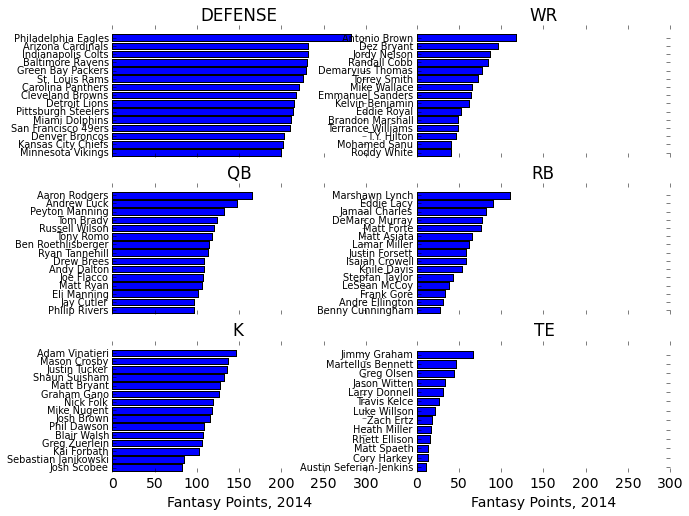

In [19]:
fig, axs = plt.subplots(3, 2, sharex=True)

positions = ('DEFENSE', 'WR', 'QB', 'RB', 'K', 'TE')
for (ax, position) in zip(axs.flatten(), positions):
    p = full_stats[full_stats.Pos == position]
    p = p[p.FantasyPtsTotal.notnull()].sort('FantasyPtsTotal', ascending=False).head(15)
    p = p.sort('FantasyPtsTotal')
    pos = [0.5 + r for r in range(p.shape[0])]
    ax.barh(pos, p.FantasyPtsTotal, align='center')
    ax.set_yticks(pos)
    if position == 'DEFENSE':
        ax.set_yticklabels(list(p.Team), size='x-small')
    else:
        ax.set_yticklabels(list(p.Player), size='x-small')
    ax.set_title(position)
    for s in ('top', 'right', 'bottom', 'left'):
        ax.spines[s].set_visible(False)
    if ax.is_last_row():
        ax.set_xlabel('Fantasy Points, 2014')
        
plt.show()

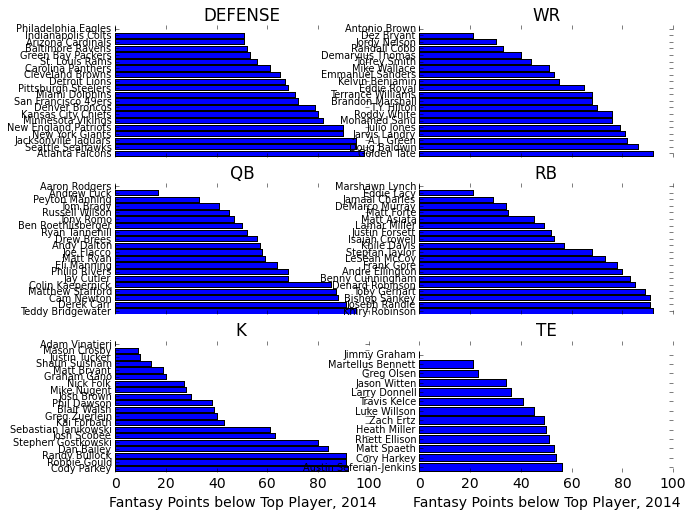

In [20]:
fig, axs = plt.subplots(3, 2, sharex=True)

for (ax, position) in zip(axs.flatten(), positions):
    p = full_stats[full_stats.Pos == position]
    p = p[p.FantasyPtsBelowBest.notnull()].sort('FantasyPtsTotal', ascending=False).head(20)
    p = p.sort('FantasyPtsTotal')
    pos = [0.5 + r for r in range(p.shape[0])]
    ax.barh(pos, p.FantasyPtsBelowBest, align='center')
    ax.set_yticks(pos)
    if position == 'DEFENSE':
        ax.set_yticklabels(list(p.Team), size='x-small')
    else:
        ax.set_yticklabels(list(p.Player), size='x-small')
    ax.set_title(position)
    for s in ('top', 'right', 'bottom', 'left'):
        ax.spines[s].set_visible(False)
    if ax.is_last_row():
        ax.set_xlabel('Fantasy Points below Top Player, 2014')
        
plt.show()